<a href="https://colab.research.google.com/github/teadrinke/LangChain/blob/main/Basic_Retrieval_Augmented_Generation(RAG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet --upgrade langchain-text-splitters langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.1 MB/s eta 0:00:00


In [2]:
!pip install -qU langchain-cohere

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.4 MB/s eta 0:00:00


#Got the LLM

In [3]:
import getpass
import os

if not os.environ.get("COHERE_API_KEY"):
  os.environ["COHERE_API_KEY"] = getpass.getpass("Enter API key for COHERE:")

from langchain_cohere import ChatCohere

llm = ChatCohere(model = "command")

Enter API key for COHERE:··········


#Got the embeddings model

In [4]:
from langchain_cohere import CohereEmbeddings

embeddings = CohereEmbeddings(model="embed-english-v3.0")

#Got the Vector Database(in memory)

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [6]:
!pip install -qU langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00


#This is one full code for RAG

In [7]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [8]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition is a process that transforms a complex task into multiple smaller and more manageable tasks that shed light on the inner thinking process of the model. This can be done through LLMs with simple prompting, by using task-specific instructions, or with human inputs.


#From the below cells it is splitted

##Loading documents

In [9]:
bs4_strainer = bs4.SoupStrainer(class_ = ("post-title", "post-header", "post-content"))

loader = WebBaseLoader(
    web_paths = ("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs = {"parse_only": bs4_strainer},
)

docs = loader.load()

In [10]:
assert len(docs) == 1
print(f"Total characters : {len(docs[0].page_content)}")

Total characters : 43131


In [11]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


##Splitting the documents

In [12]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200, #chunk overlap is there for maintaining context
    add_start_index = True, #track index in original document
)

all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


##Indexing the chunks

In [13]:
document_ids = vector_store.add_documents(documents = all_splits)

print(document_ids[:3])

['ec7cc312-f399-4fe7-9783-3332506213c5', '70237511-9a2b-4c1d-8ac2-6cf703555c3d', '0b6a4a08-b2ec-43cd-987b-3013b1a09236']


#Retrieval and Generation

In [14]:
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
      {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [15]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
  question : str
  context : List[Document]
  answer : str

In [16]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [17]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

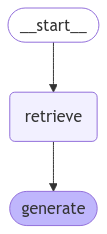

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='d6120869-da15-45c5-9c12-84a0cdc4174a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='fbab8224-ede4-4a59-ab08-90be284f78a2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023

##Returning the sources

In [20]:
from langchain_core.prompts import PromptTemplate

template = '''Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:'''

custom_rag_template = PromptTemplate.from_template(template)

#Query analysis

####Query analysis employs models to transform or construct optimized search queries from raw user input. We can easily incorporate a query analysis step into our application

In [21]:
total_documents = len(all_splits)
third = total_documents//3

for i, document in enumerate(all_splits):
  if i< third:
    document.metadata["section"] = "beginning"
  elif i<2*third:
    document.metadata["section"] = "middle"
  else:
    document.metadata["section"] = "end"

all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [22]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [23]:
from typing import Literal

from typing_extensions import Annotated

class Search(TypedDict):
  """Search Query."""

  query : Annotated[str, ... , "Search query to run."]
  section : Annotated[
      Literal["beginning", "middle", "end"],
      ...,
      "Section to query.",
  ]

In [25]:
class State(TypedDict):
  question : str
  query : Search
  context : List[Document]
  answer : str

def analyze_query(state : State):
  structured_llm = llm.with_structured_output(Search)
  query = structured_llm.invoke(state["question"])
  return {"query" : query}

def retrieve(state : State):
  query = state["query"]
  retrieved_docs = vector_store.similarity_search(
      query = ["query"],
      filter = lambda doc: doc.metadata.get("section") == query["section"],
  )

  return {"context" : retrieved_docs}

def generate(state : State):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = prompt.invoke({"question" : state["question"], "context" : docs_content})
  response = llm.invoke(messages)
  return {"answer" : response.content}



graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

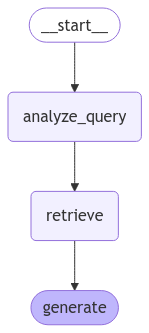

In [26]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

BadRequestError: status_code: 400, body: {'message': 'invalid request: tool use is not supported by the provided model: command.'}